In [0]:
import requests
url = 'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip'
target_path = '/content/drive/My Drive/MPI_D2/train.zip'

response = requests.get(url, stream=True)
handle = open(target_path, "wb")
for chunk in response.iter_content(chunk_size=512):
    if chunk:  # filter out keep-alive new chunks
        handle.write(chunk)
handle.close()

In [0]:
import requests
url = 'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip'
target_path = '/content/drive/My Drive/MPI_D2/test.zip'

response = requests.get(url, stream=True)
handle = open(target_path, "wb")
for chunk in response.iter_content(chunk_size=512):
    if chunk:  # filter out keep-alive new chunks
        handle.write(chunk)
handle.close()

In [0]:
import requests
url = 'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip'
target_path = '/content/drive/My Drive/MPI_D2/valid.zip'

response = requests.get(url, stream=True)
handle = open(target_path, "wb")
for chunk in response.iter_content(chunk_size=512):
    if chunk:  # filter out keep-alive new chunks
        handle.write(chunk)
handle.close()

Run from here

In [0]:
!unzip -q '/content/drive/My Drive/MPI_D2/test.zip'

In [0]:
!unzip -q '/content/drive/My Drive/MPI_D2/train.zip'
!unzip -q '/content/drive/My Drive/MPI_D2/valid.zip'

Importing Libraries

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_files
import keras 
from keras.utils import np_utils
from glob import glob

Import Dataset

In [0]:
def load_dataset(path):
    data = load_files(path, shuffle=True)
    img_files = np.array(data['filenames'])
    img_targets = np_utils.to_categorical(np.array(data['target']), 3)
    return img_files, img_targets

In [0]:
cd 

drive  sample_data


In [0]:
train_files, train_labels = load_dataset('train')
valid_files, valid_labels = load_dataset('valid')

In [0]:
def load_dataset_no_shuffle(path):
    data = load_files(path, shuffle=False)
    img_files = np.array(data['filenames'])
    img_targets = np_utils.to_categorical(np.array(data['target']), 3)
    return img_files, img_targets

In [0]:
test_files , test_labels = load_dataset_no_shuffle('test')

In [0]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(path):
    
    img = image.load_img(path, target_size = (224,224))
    x= image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(paths):
    list_of_tensors = [path_to_tensor(path) for path in tqdm(paths)]
    return np.vstack(list_of_tensors)

In [42]:
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 600/600 [08:04<00:00,  1.24it/s]


Train

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

In [44]:
from keras.applications.resnet50 import ResNet50

model_resnet = ResNet50(weights = 'imagenet', include_top = False)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [45]:
train_features_inception = model_resnet.predict(train_tensors, verbose=1)
valid_features_inception = model_resnet.predict(valid_tensors, verbose=1)
test_features_inception = model_resnet.predict(test_tensors, verbose=1)

600/600 [==============================] - 7s 12ms/step


In [46]:
model = Sequential()

model.add(GlobalAveragePooling2D(input_shape = train_features_inception.shape[1:]))
model.add(Dropout(0.2))
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation ='softmax'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

In [0]:

opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)
model.compile(optimizer= opt, metrics = ['accuracy'], loss='categorical_crossentropy')

In [50]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(save_best_only = True, verbose =1, 
                             filepath = 'saved_models/weights.best.from_resnet.hdf5')

model.fit(train_features_inception, 
          train_labels, 
          epochs=100, 
          batch_size= 64, 
          validation_data=(valid_features_inception, valid_labels), callbacks=[checkpoint], verbose=1
         )

Train on 2000 samples, validate on 150 samples
Epoch 1/100
2000/2000 [==============================] - 1s 398us/step - loss: 0.8490 - accuracy: 0.6860 - val_loss: 1.0679 - val_accuracy: 0.5200

Epoch 00001: val_loss improved from inf to 1.06788, saving model to saved_models/weights.best.from_resnet.hdf5
Epoch 2/100
2000/2000 [==============================] - 1s 397us/step - loss: 0.8475 - accuracy: 0.6860 - val_loss: 1.0643 - val_accuracy: 0.5200

Epoch 00002: val_loss improved from 1.06788 to 1.06429, saving model to saved_models/weights.best.from_resnet.hdf5
Epoch 3/100
2000/2000 [==============================] - 1s 405us/step - loss: 0.8450 - accuracy: 0.6860 - val_loss: 1.0655 - val_accuracy: 0.5200

Epoch 00003: val_loss did not improve from 1.06429
Epoch 4/100
2000/2000 [==============================] - 1s 394us/step - loss: 0.8458 - accuracy: 0.6860 - val_loss: 1.0536 - val_accuracy: 0.5200

Epoch 00004: val_loss improved from 1.06429 to 1.05361, saving model to saved_models

In [0]:

model.load_weights('saved_models/weights.best.from_resnet.hdf5')

In [54]:
test_predictions = np.argmax(model.predict(test_features_inception), axis=1)
accuracy = 100 * np.sum(np.array(test_predictions) == np.argmax(test_labels, axis=1))/len(test_predictions)
print ('Accuracy of ResNet model on test set = %.4f%%' % accuracy)

Accuracy of ResNet model on test set = 65.5000%


In [55]:
print(np.argmax(test_labels[25]))
print(test_predictions[25])

0
1


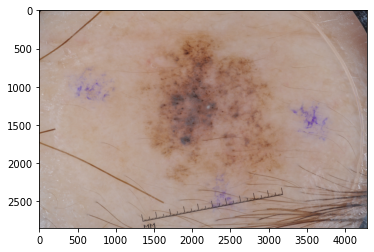

In [56]:
import cv2
img = cv2.imread(test_files[25])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()


InceptionResNetV2

In [60]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

model_inception_resnet = InceptionResNetV2(weights = 'imagenet', include_top = False)

219062272/219055592 [==============================] - 19s 0us/step


In [61]:
model_inception_resnet = Sequential()

model_inception_resnet.add(GlobalAveragePooling2D(input_shape = train_features_inception.shape[1:]))
model_inception_resnet.add(Dropout(0.2))
model_inception_resnet.add(Dense(1024, activation = 'relu'))
model_inception_resnet.add(Dropout(0.2))
model_inception_resnet.add(Dense(512, activation = 'relu'))
model_inception_resnet.add(Dropout(0.2))
model_inception_resnet.add(Dense(128, activation = 'relu'))
model_inception_resnet.add(Dropout(0.2))
model_inception_resnet.add(Dense(3, activation ='softmax'))


model_inception_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

In [0]:
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)
model_inception_resnet.compile(optimizer= opt, metrics = ['accuracy'], loss='categorical_crossentropy')

In [64]:

from keras.callbacks import ModelCheckpoint

checkpoint_inception = ModelCheckpoint(
    save_best_only = True, 
    verbose = 1, 
    filepath = 'saved_models/weights.best.from_inception_resnet_v2.hdf5')

model_inception_resnet.fit(train_features_inception, 
          train_labels, 
          epochs=100, 
          batch_size= 64, 
          validation_data=(valid_features_inception, valid_labels), callbacks=[checkpoint_inception], verbose=1
         )

Train on 2000 samples, validate on 150 samples
Epoch 1/100
2000/2000 [==============================] - 1s 412us/step - loss: 0.8479 - accuracy: 0.6860 - val_loss: 1.0478 - val_accuracy: 0.5200

Epoch 00001: val_loss improved from inf to 1.04783, saving model to saved_models/weights.best.from_inception_resnet_v2.hdf5
Epoch 2/100
2000/2000 [==============================] - 1s 402us/step - loss: 0.8539 - accuracy: 0.6860 - val_loss: 1.0470 - val_accuracy: 0.5200

Epoch 00002: val_loss improved from 1.04783 to 1.04697, saving model to saved_models/weights.best.from_inception_resnet_v2.hdf5
Epoch 3/100
2000/2000 [==============================] - 1s 398us/step - loss: 0.8535 - accuracy: 0.6860 - val_loss: 1.0615 - val_accuracy: 0.5200

Epoch 00003: val_loss did not improve from 1.04697
Epoch 4/100
2000/2000 [==============================] - 1s 389us/step - loss: 0.8487 - accuracy: 0.6860 - val_loss: 1.0487 - val_accuracy: 0.5200

Epoch 00004: val_loss did not improve from 1.04697
Epoch 5

In [0]:
model_inception_resnet.load_weights('saved_models/weights.best.from_inception_resnet_v2.hdf5')

In [66]:
test_predictions = np.argmax(model_inception_resnet.predict(test_features_inception), axis=1)
accuracy = 100 * np.sum(np.array(test_predictions) == np.argmax(test_labels, axis=1))/len(test_predictions)
print ('Accuracy of Inception model on test set = %.4f%%' % accuracy)

Accuracy of Inception model on test set = 65.5000%


INCEPTION

In [69]:
from keras.applications.inception_v3 import InceptionV3

model_inception = InceptionV3(weights = 'imagenet', include_top = False)

87916544/87910968 [==============================] - 7s 0us/step


In [70]:
train_features_inception = model_inception.predict(train_tensors, verbose=1)
valid_features_inception = model_inception.predict(valid_tensors, verbose=1)
test_features_inception = model_inception.predict(test_tensors, verbose=1)

600/600 [==============================] - 6s 10ms/step


In [71]:
model = Sequential()

model.add(GlobalAveragePooling2D(input_shape = train_features_inception.shape[1:]))
model.add(Dropout(0.2))
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation ='softmax'))


model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)              

In [0]:
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)
model.compile(optimizer= opt, metrics = ['accuracy'], loss='categorical_crossentropy')

In [74]:

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(save_best_only = True, verbose =1, 
                             filepath = 'saved_models/weights.best.from_inception.hdf5')

model.fit(train_features_inception, 
          train_labels, 
          epochs=100, 
          batch_size= 64, 
          validation_data=(valid_features_inception, valid_labels), callbacks=[checkpoint], verbose=1
         )

Train on 2000 samples, validate on 150 samples
Epoch 1/100
2000/2000 [==============================] - 1s 310us/step - loss: 0.3436 - accuracy: 0.8650 - val_loss: 0.8387 - val_accuracy: 0.7000

Epoch 00001: val_loss improved from inf to 0.83872, saving model to saved_models/weights.best.from_inception.hdf5
Epoch 2/100
2000/2000 [==============================] - 1s 325us/step - loss: 0.3469 - accuracy: 0.8565 - val_loss: 0.8518 - val_accuracy: 0.7200

Epoch 00002: val_loss did not improve from 0.83872
Epoch 3/100
2000/2000 [==============================] - 1s 316us/step - loss: 0.3315 - accuracy: 0.8675 - val_loss: 0.9352 - val_accuracy: 0.7267

Epoch 00003: val_loss did not improve from 0.83872
Epoch 4/100
2000/2000 [==============================] - 1s 302us/step - loss: 0.3327 - accuracy: 0.8705 - val_loss: 0.8835 - val_accuracy: 0.7333

Epoch 00004: val_loss did not improve from 0.83872
Epoch 5/100
2000/2000 [==============================] - 1s 306us/step - loss: 0.3063 - accura

In [0]:
model.load_weights('saved_models/weights.best.from_inception.hdf5')

In [76]:
test_predictions = np.argmax(model.predict(test_features_inception), axis=1)
accuracy = 100 * np.sum(np.array(test_predictions) == np.argmax(test_labels, axis=1))/len(test_predictions)
print ('Accuracy of Inception model on test set = %.4f%%' % accuracy)

Accuracy of Inception model on test set = 67.0000%
